In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import timm
import random

In [2]:
dataset_path = './Rice_Image_Dataset'
classes = []

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):  # Check if it's a directory
        classes.append(folder)


In [3]:
img_sample = []
for cat in classes:
    folder_path = os.path.join(dataset_path, cat)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)
        img_sample.append(img)
        break

In [4]:
all_images = []
all_labels = []

for label in classes:
    folder = os.path.join(dataset_path, label)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        all_images.append(img_path)
        all_labels.append(label)

In [5]:
# Split data into training and temporary (val+test) sets
train_images, temp_images, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=0.4, stratify=all_labels, random_state=42
)

# Split the temporary set into validation and test sets
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
        self.label_to_int = {label: idx for idx, label in enumerate(sorted(set(labels)))}

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')  # Convert to RGB in case some images are grayscale

        if self.transform:
            image = self.transform(image)
        
        # Convert the label from string to integer
        label = self.label_to_int[label]

        return image, label


In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_dataset = CustomImageDataset(train_images, train_labels, transform=transform)
val_dataset = CustomImageDataset(val_images, val_labels, transform=transform)
test_dataset = CustomImageDataset(test_images, test_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [8]:
class NasNet(nn.Module):
    def __init__(self, num_classes=5):  # Assuming 5 classes for classification
        super(NasNet, self).__init__()
        self.nasnet= timm.create_model('mnasnet_100', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.nasnet(x)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NasNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)


Downloading:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

C:\Users\VSA\anaconda3\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\VSA\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [10]:
num_epochs = 3
line1=[]
line2=[]
line3=[]
line4=[]

In [11]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data)
        # Compute the training loss
        loss = criterion(outputs, target)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        # Compute training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    # Validation
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            # Compute the validation loss
            val_loss = criterion(outputs, target)
            total_val_loss += val_loss.item()
            # Compute validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    line1.append(train_accuracy)
    line2.append(val_accuracy)
    line3.append(avg_train_loss)
    line4.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}%, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}%")


Epoch 1/3, Training Loss: 0.0557, Training Accuracy: 98.4489%, Validation Loss: 0.0619, Validation Accuracy: 97.6400%
Epoch 2/3, Training Loss: 0.0161, Training Accuracy: 99.5311%, Validation Loss: 0.0122, Validation Accuracy: 99.5867%
Epoch 3/3, Training Loss: 0.0139, Training Accuracy: 99.6378%, Validation Loss: 0.0059, Validation Accuracy: 99.8667%


Test Accuracy: 99.9000


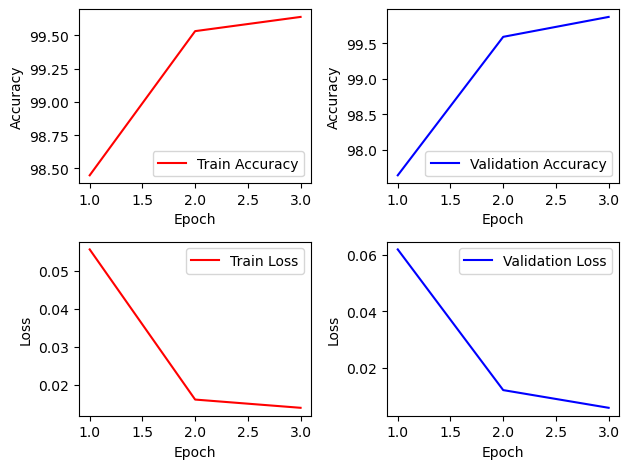

In [12]:
correct = 0
total = 0

with torch.no_grad():
    model.eval()
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100
print(f"Test Accuracy: {accuracy:.4f}")

epoch_numbers=[i+1 for i in range(num_epochs)]
plt.figure()
plt.subplot(2, 2, 1) 
plt.plot(epoch_numbers, line1, label='Train Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(2, 2, 2)  
plt.plot(epoch_numbers, line2, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3) 
plt.plot(epoch_numbers, line3, label='Train Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(2, 2, 4)  
plt.plot(epoch_numbers, line4, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()  # 서브플롯간 간격 조절
plt.show()

In [13]:
torch.save(model.state_dict(), 'pre_NasNet.pt')